In [1]:
# Necessary on my mac. Not best practice, but **usually** works.
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
# import numpy and pytorch
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as utils

In [ ]:
# import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import rasterio as rio
import geopandas as gpd

import warnings

from itertools import product

import pandas as pd

# Read files
wu = gpd.read_file('pspws/for ellie/wu_durham.shp')
coords = np.vstack([wu.geometry.x, wu.geometry.y]).T
bounds = wu.total_bounds


[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


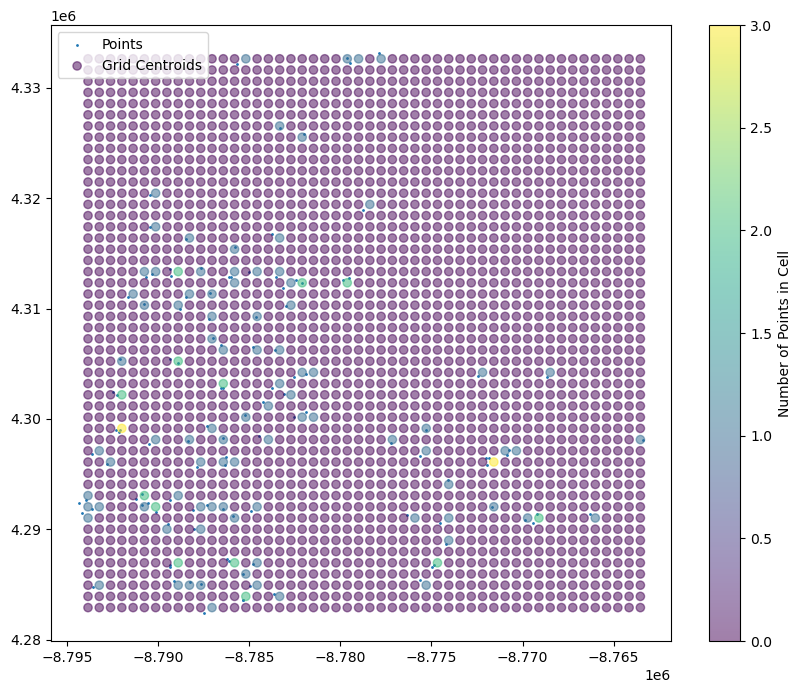

In [4]:
xy = coords

cells_x = 50
cells_y = 50
resolution = (bounds[2] - bounds[0]) / cells_x

area_per_cell = resolution**2

# Creating bin edges for a 2D histogram
quadrat_x = np.linspace(bounds[0], bounds[2], cells_x + 1)
quadrat_y = np.linspace(bounds[1], bounds[3], cells_y + 1)

# Identifying the midpoints of each grid cell
centroids = np.asarray(list(product(quadrat_x[:-1] + 500, quadrat_y[:-1] + 500))) # Why adding 500 to each here?

cell_counts, _, _ = np.histogram2d(xy[:, 0], xy[:, 1], [quadrat_x, quadrat_y])
print(cell_counts)
cell_counts = cell_counts.ravel().astype(int)

# Optionally, visualize data
plt.figure(figsize=(10, 8))
plt.scatter(coords[:, 0], coords[:, 1], s=1, label='Points')
plt.scatter(centroids[:, 0], centroids[:, 1], c=cell_counts, cmap='viridis', label='Grid Centroids', alpha=0.5)
plt.colorbar(label='Number of Points in Cell')
plt.legend()
plt.show()


/var/folders/nd/v9lp325j6vx2vr517r25j0q00000gn/T/ipykernel_65981/2323270611.py:14: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


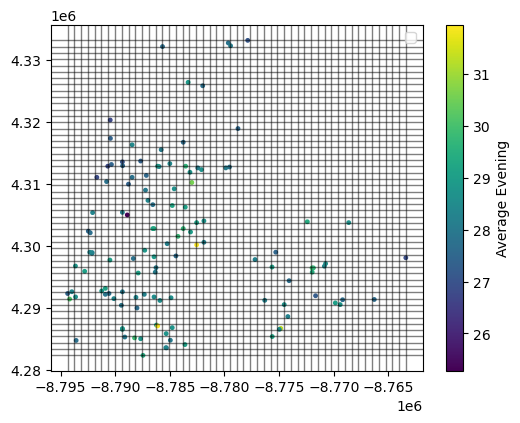

In [5]:
# Plotting
line_kwargs = {"color": "k", "linewidth": 1, "alpha": 0.5}

plt.figure(figsize=(6, 4.5))
[plt.axhline(y, **line_kwargs) for y in quadrat_y]
[plt.axvline(x, **line_kwargs) for x in quadrat_x]
plt.scatter(wu.geometry.x, wu.geometry.y, c=wu["eve_avg"], s=6)
# add color bar
plt.colorbar(label="Average Evening")

# Plotting the centroids
# plt.scatter(centroid_meshgrid_x, centroid_meshgrid_y, color='red', s=10, label='Centroids')

plt.legend()
plt.show()

# for i, row in enumerate(centroids):
#     shifted_row = row - 2
#     plt.annotate(cell_counts[i], shifted_row, alpha=0.75)

In [6]:
avg_values = []

for x1, x2 in zip(quadrat_x[:-1], quadrat_x[1:]):
    for y1, y2 in zip(quadrat_y[:-1], quadrat_y[1:]):
        # Calculate average of the wu data that falls in this cell
        mask = (wu.geometry.x > x1) & (wu.geometry.x < x2) & (wu.geometry.y > y1) & (wu.geometry.y < y2)
        if mask.sum() == 0:
            avg_values.append(None)
        else:
            avg_values.append(wu[mask]['eve_avg'].mean())

print(avg_values)

[None, None, None, None, None, None, None, None, np.float64(30.101881720430107), None, np.float64(28.382749326145554), None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, np.float64(27.701666666666664), None, None, None, None, None, None, np.float64(28.709946236559137), None, None, None, None, np.float64(28.814285714285717), None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, np.float64(29.058333333333337), None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, Non

In [7]:
# Create a geopandas dataframe
df = pd.DataFrame(
    {
        'eve_avg': avg_values,
        'cell_counts': cell_counts,
        'latitude': centroids[:, 1],
        'longitude': centroids[:, 0]
    }
)

gdf = gpd.GeoDataFrame(df,
    geometry=gpd.points_from_xy(centroids[:, 0], centroids[:, 1]),
    crs=wu.crs
)


In [8]:
coords = np.vstack([gdf.geometry.x, gdf.geometry.y]).T
X = coords
temp = gdf['eve_avg'] # temp stores the eve_avg temperatures for all the grid cells

# Now, we want to separate points into the 'observed' and unobserved categories
# A centroid counts as 'observed' if the corresponding grid cell contains at least one initial point 
#   (in this case, we'll take the average of the points in that cell as the 'value' of the centroid)

# array of indices corresponding to centroids with cell_counts > 0:
observed = np.where(cell_counts > 0)[0]
X_observed = centroids[observed]



In [9]:
def RBFkernel(x1, x2, l=1.0, sigma_f=1.0, sigma_n=1e-2, noise=False):
    '''
    Isotropic squared exponential kernel. Computes 
    a covariance matrix from points in x1 and x2.
        
    Args:
        x1: Array of m points (m x d).
        x2: Array of n points (n x d).
        l: Length scale parameter.
        sigma_f: Signal variance parameter.
        
    Returns:
        Covariance matrix (m x n).
    '''
    # compute squared distance between points in x1 and x2
    sqdist = np.sum(x1**2, 1).reshape(-1, 1) + np.sum(x2**2, 1) - 2 * np.dot(x1, x2.T)
    if noise == True: # If noise=True, add noise to cov matrix by incrementing diagonal elements by (sigma_n)^2, where x1 and x2 points are identical:
        sig_tmp=sigma_f**2 * np.exp(-0.5 / l**2 * sqdist)
        for i,x1i in enumerate(x1):
            for j,x2j in enumerate(x2):
                if np.array_equal(x1i,x2j):
                    sig_tmp[i,j]+=sigma_n**2
        return sig_tmp
    else: # if noise=False, the covariance matrix is computed directly (without noise included)
        return sigma_f**2 * np.exp(-0.5 / l**2 * sqdist) 

In [10]:
is_nan = np.isnan(temp[observed])

X_observed = X_observed[~is_nan]
temp_observed = temp[observed][~is_nan] - temp[observed][~is_nan].mean()
observed = observed[~is_nan]

assert len(observed) == len(X_observed) == len(temp_observed)

# need to normalize the data
temp_norm = (temp_observed - np.mean(temp_observed)) / np.std(temp_observed)
# print(np.mean(temp_norm), np.std(temp_norm))


0.612**2 * RBF(length_scale=2.57e+03)


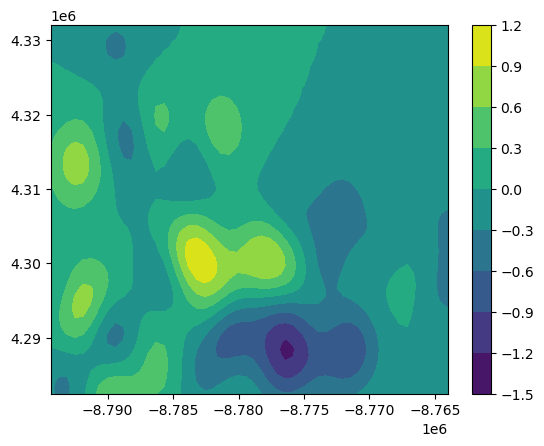

In [11]:
#### THIS IS USEFUL FOR FITTING THE KERNEL....

from sklearn.gaussian_process import GaussianProcessRegressor, kernels

k = 0.5**2 * kernels.RBF(length_scale=1.0) #+ kernels.WhiteKernel(noise_level=1e-5)

gp = GaussianProcessRegressor(kernel=k, n_restarts_optimizer=10, alpha=0.5)

gp.fit(X_observed, temp_norm)

print(gp.kernel_)

# plot the gp as contour plot
plt.contourf(quadrat_x[:-1], quadrat_y[:-1], gp.predict(coords).reshape(cells_x, cells_y), cmap='viridis')
plt.colorbar()


In [37]:
np.random.seed(42)

# Calculate the covariance matrix using the Matern kernel
ls = 2.57e03
s = 0.6
n = 0.5
K = RBFkernel(X, X, l=ls, sigma_f=s, noise=True, sigma_n=n)


(50, 50)


In [13]:
# Infer the remaining points using the observed points
# calculate the covariance matrix for the observed points
K_observed = RBFkernel(X_observed, X_observed, l=ls, sigma_f=s, noise=True, sigma_n=0.1)
# calculate the covariance matrix between the observed and unobserved points
K_cross = RBFkernel(X_observed, X, l=ls, sigma_f=s, noise=False)
# calculate the covariance matrix for the unobserved points
K_uncross = RBFkernel(X, X, l=ls, sigma_f=s, noise=True, sigma_n=0.1)

# calculate the mean of the posterior
mu_post = np.mean(temp_observed) + np.dot(np.dot(K_cross.T, np.linalg.inv(K_observed)), (temp_observed - np.mean(temp_observed)))
# The posterior mean  provides the predicted values at all grid points (both observed and unobserved) based on the fitted GPR model.

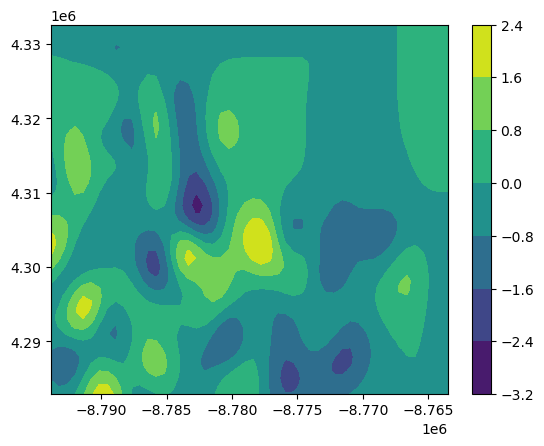

In [15]:
# Reshape the grid for visualization
X1, X2 = np.meshgrid(quadrat_x[:-1] + 500, quadrat_y[:-1] + 500)
plt.contourf(X1, X2, mu_post.reshape(X1.shape))
plt.colorbar()

In [16]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def softmax(x):
    return np.exp(x) / np.sum(np.exp(x))

(array([4., 0., 0., 0., 1., 4., 2., 2., 7., 2., 5., 5., 6., 3., 8., 5., 3.,
        3., 6., 7., 3., 3., 7., 2., 0., 2., 0., 1., 2., 1., 2., 0., 1., 0.,
        0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]),
 array([-1.93811895, -1.81832606, -1.69853317, -1.57874027, -1.45894738,
        -1.33915448, -1.21936159, -1.09956869, -0.9797758 , -0.85998291,
        -0.74019001, -0.62039712, -0.50060422, -0.38081133, -0.26101843,
        -0.14122554, -0.02143265,  0.09836025,  0.21815314,  0.33794604,
         0.45773893,  0.57753182,  0.69732472,  0.81711761,  0.93691051,
         1.0567034 ,  1.1764963 ,  1.29628919,  1.41608208,  1.53587498,
         1.65566787,  1.77546077,  1.89525366,  2.01504655,  2.13483945,
         2.25463234,  2.37442524,  2.49421813,  2.61401103,  2.73380392,
         2.85359681,  2.97338971,  3.0931826 ,  3.2129755 ,  3.33276839,
         3.45256129,  3.57235418,  3.69214707,  3.81193997,  3.93173286,
         4.05152576]),
 <BarContainer object

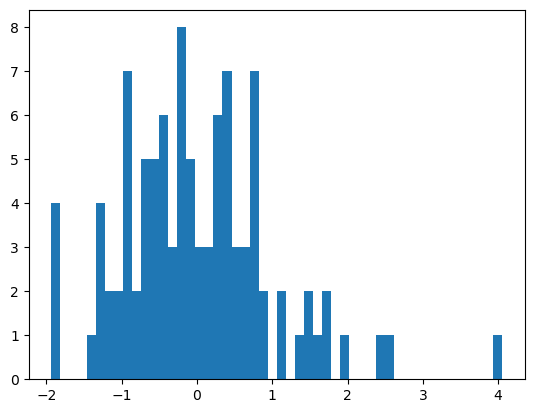

In [17]:
# plot histogram of temp_norm
plt.hist(temp_norm, bins=50)
# remove outlier point at 4?

tensor(1.3199, grad_fn=<SubBackward0>)
tensor(1.3035, grad_fn=<SubBackward0>)
tensor(1.2874, grad_fn=<SubBackward0>)
tensor(1.2716, grad_fn=<SubBackward0>)
tensor(1.2560, grad_fn=<SubBackward0>)
tensor(1.2406, grad_fn=<SubBackward0>)
tensor(1.2255, grad_fn=<SubBackward0>)
tensor(1.2106, grad_fn=<SubBackward0>)
tensor(1.1960, grad_fn=<SubBackward0>)
tensor(1.1816, grad_fn=<SubBackward0>)
tensor(1.1675, grad_fn=<SubBackward0>)
tensor(1.1536, grad_fn=<SubBackward0>)
tensor(1.1400, grad_fn=<SubBackward0>)
tensor(1.1266, grad_fn=<SubBackward0>)
tensor(1.1134, grad_fn=<SubBackward0>)
tensor(1.1005, grad_fn=<SubBackward0>)
tensor(1.0877, grad_fn=<SubBackward0>)
tensor(1.0753, grad_fn=<SubBackward0>)
tensor(1.0630, grad_fn=<SubBackward0>)
tensor(1.0510, grad_fn=<SubBackward0>)
tensor(1.0392, grad_fn=<SubBackward0>)
tensor(1.0276, grad_fn=<SubBackward0>)
tensor(1.0162, grad_fn=<SubBackward0>)
tensor(1.0050, grad_fn=<SubBackward0>)
tensor(0.9941, grad_fn=<SubBackward0>)
tensor(0.9833, grad_fn=<S

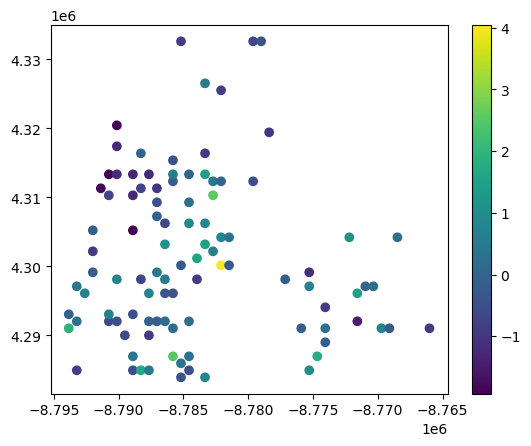

In [18]:
# can we do bias correction?
# define M as whether an observation was sampled or not
scaling = -2
scaling_intercept = -1
M = np.zeros(X.shape[0])
M[observed] = 1

# define z_inferred starting a pytorch tensor of zeros, trainable
z_inferred = torch.zeros(X.shape[0], requires_grad=True)
# define a trainable parameter for the observation link to z
observation_link = torch.tensor(scaling, requires_grad=False)
intercept = torch.tensor(scaling_intercept, requires_grad=False)
# define the optimizer
optimizer = optim.Adam([z_inferred], lr=0.01)
# define the loss function
observation_matching = nn.MSELoss()
missingness = nn.CrossEntropyLoss()
# define the number of iterations
iters = 1000
# create pytorch tensors for the observed points and values
X_observed_pt = torch.tensor(X_observed, dtype=torch.float32)
z_observed_pt = torch.from_numpy(temp_norm.values).float()

# torch.tensor(temp_observed, dtype=torch.float32)
# create pytorch tensors for the covariance matrices
K_observed_pt = torch.tensor(K_observed, dtype=torch.float32)
# create a pytorch tensor for the full covariance matrix
K_inv_pt = torch.inverse(torch.tensor(K, dtype=torch.float32))
# create a pytorch tensor for the missingness
M_pt = torch.tensor(M, dtype=torch.float32)

for iter in range(iters):
    # zero the gradient
    optimizer.zero_grad()
    
    # calculate the loss on the quadratic term in the normal, which is z^T K^{-1} z
    loss = .5*torch.matmul(torch.matmul(z_inferred-0.5, K_inv_pt), z_inferred-0.5)/z_inferred.shape[0]
    loss += observation_matching(z_observed_pt, z_inferred[observed])
    loss -= torch.mean(M_pt*torch.log(torch.softmax(intercept + observation_link*z_inferred, dim=0)) + (1-M_pt)*torch.log(1-torch.softmax(intercept + observation_link*z_inferred, dim=0)))
    # calculate the gradient
    loss.backward()
    # take a step
    optimizer.step()
    # print the loss
    print(loss)

# plot z_observed_pt
plt.scatter(X_observed_pt[:, 0].detach().numpy(), X_observed_pt[:, 1].detach().numpy(), c=z_observed_pt.detach().numpy())
plt.colorbar()
plt.show()

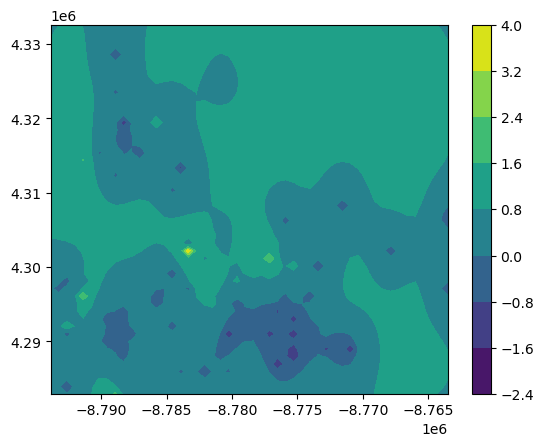

In [19]:
# detach z_inferred and plot
plt.contourf(X1, X2, z_inferred.detach().numpy().reshape(X1.shape))#, vmin=cbar_min, vmax=cbar_max)
plt.colorbar()
plt.show()


### Preferential Sampling

We want to show that our model adjusts for preferential sampling, which leads to better estimates on a synthetic dataset.

In [91]:
import numpy as np
from sklearn.gaussian_process.kernels import RBF
from sklearn.metrics.pairwise import pairwise_kernels

x = np.linspace(0, 10, 50)
y = np.linspace(0, 10, 50)
X, Y = np.meshgrid(x, y)

grid_points = np.vstack([X.ravel(), Y.ravel()]).T

In [92]:
kernel = RBF(length_scale=1.0)
covariance_matrix = pairwise_kernels(grid_points, metric='rbf', gamma=1.0/(2*1.0**2))

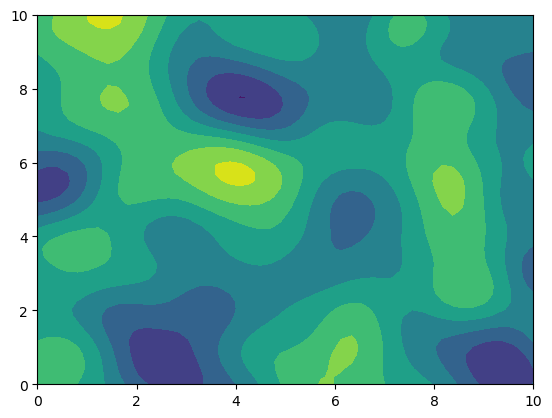

In [93]:
mean = np.zeros(grid_points.shape[0])
# Draw random samples from MVN:
process_values = np.random.multivariate_normal(mean, covariance_matrix)
# Create contour plot of process values

process_values_grid = process_values.reshape(X.shape)
plt.contourf(X, Y, process_values_grid)

In [94]:
def preferential_sampling(points, values, n_samples=50):
    # define the likelihood of sampling a location as a function of its value
    scaling = 2.
    probabilities = softmax(scaling*values)
    # Points with higher probabilities (derived from higher values) are more likely to be sampled
    sampled_indices = np.random.choice(len(points), size=n_samples, p=probabilities, replace=False)
    return points[sampled_indices], values[sampled_indices], sampled_indices

# Sample points from the grid preferentially
sampled_points, sampled_values, sampled_indices = preferential_sampling(grid_points, process_values)
print("Sampled Points:\n", sampled_points)
print("Sampled Values:\n", sampled_values)

Sampled Points:
 [[ 7.75510204 10.        ]
 [ 0.20408163  9.59183673]
 [ 1.02040816  9.79591837]
 [ 1.63265306  9.3877551 ]
 [ 6.32653061  1.63265306]
 [ 2.65306122  4.89795918]
 [ 5.10204082  0.        ]
 [ 4.08163265  5.30612245]
 [ 6.53061224  1.83673469]
 [ 8.36734694  5.71428571]
 [ 0.81632653  7.55102041]
 [ 2.04081633  9.59183673]
 [ 7.14285714  8.57142857]
 [ 0.         10.        ]
 [ 6.53061224  0.6122449 ]
 [ 6.93877551  0.        ]
 [ 0.81632653  7.34693878]
 [ 3.67346939  5.30612245]
 [ 3.67346939  5.10204082]
 [ 2.24489796  5.51020408]
 [ 7.14285714  5.10204082]
 [ 3.87755102  5.91836735]
 [ 4.08163265  5.71428571]
 [ 4.08163265  5.91836735]
 [ 8.16326531  7.34693878]
 [ 5.10204082  5.51020408]
 [ 3.46938776  5.10204082]
 [ 0.81632653  3.67346939]
 [ 3.67346939  5.51020408]
 [ 0.81632653  8.57142857]
 [ 1.63265306  8.7755102 ]
 [ 1.83673469  7.34693878]
 [ 4.28571429  4.89795918]
 [ 2.24489796  6.32653061]
 [ 4.08163265  6.12244898]
 [ 3.06122449  5.91836735]
 [ 3.061224

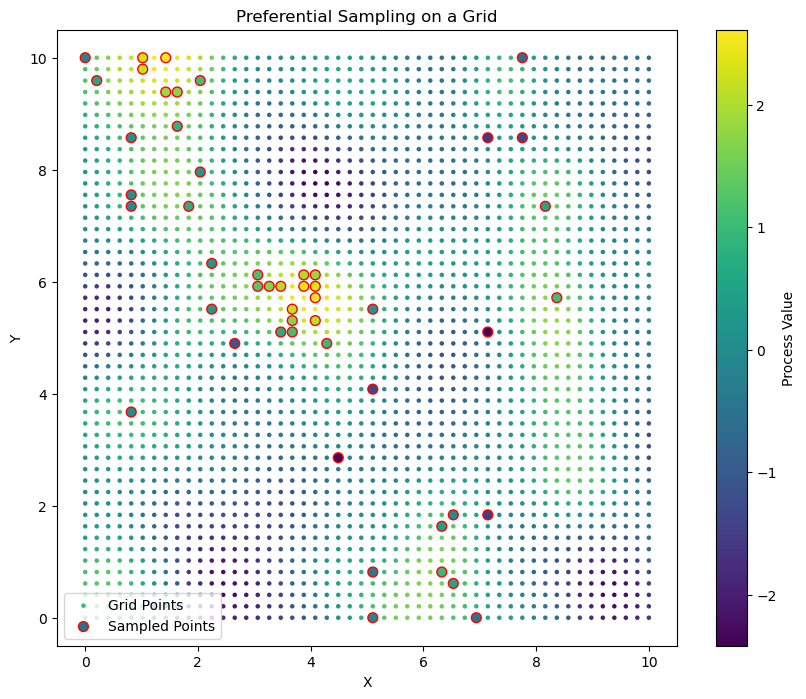

In [95]:
# Visualization with color coding based on values
plt.figure(figsize=(10, 8))
scatter = plt.scatter(grid_points[:, 0], grid_points[:, 1], c=process_values, cmap='viridis', s=5, label='Grid Points')
plt.scatter(sampled_points[:, 0], sampled_points[:, 1], c=sampled_values, cmap='viridis', edgecolor='red', s=50, label='Sampled Points', marker='o')
plt.colorbar(scatter, label='Process Value')
plt.title("Preferential Sampling on a Grid")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.show()

Because we have the ground truth, we want to make sure that our method can better predict at the unsampled locations (i.e., the MSE is lower on the held-out data).

In [96]:
# Split data into training and testing:
n_samples = 50
all_indices = np.arange(len(grid_points))
unsampled_indices = np.setdiff1d(all_indices, sampled_indices) # finds set difference

# Training data (preferentially sampled)
X_train = sampled_points
y_train = sampled_values
# Testing data (unsampled)
X_test = grid_points[unsampled_indices]
y_test = process_values[unsampled_indices]

In [97]:
# Fit and predict with basic GP (no preferential sampling adjustment)

from sklearn.gaussian_process import GaussianProcessRegressor
# Initialize and fit the basic GP model
basic_gp = GaussianProcessRegressor(kernel=kernel, alpha=0.1)
basic_gp.fit(X_train, y_train)
y_pred_basic, y_std_basic = basic_gp.predict(X_test, return_std=True)

In [114]:
def custom_gp_predict(X_train, y_train, X_test, K, iters=1000, lr=1., scaling=2, scaling_intercept=-1):

    observed = np.arange(X_train.shape[0])
    M = np.zeros(X_train.shape[0] + X_test.shape[0])
    M[observed] = 1
    M = torch.tensor(M, dtype=torch.float32)

    z_inferred = torch.zeros(X_train.shape[0] + X_test.shape[0], requires_grad=True)

    # trainable parameters for the observation link to z
    observation_link = torch.tensor(scaling, requires_grad=False)
    intercept = torch.tensor(scaling_intercept, requires_grad=False)

    optimizer = optim.Adam([z_inferred], lr=lr)
    observation_matching = nn.MSELoss()

    # Create tensors for the observed points and values
    X_train_pt = torch.tensor(X_train, dtype=torch.float32)
    y_train_pt = torch.tensor(y_train, dtype=torch.float32)
    X_combined = np.vstack((X_train, X_test))
    K_combined = RBFkernel(X_combined, X_combined, l=1., sigma_f=1., noise=True, sigma_n=0.01)
    # print stability of K_combined
    print(np.linalg.cond(K_combined))
    K_inv_pt = torch.inverse(torch.tensor(K_combined, dtype=torch.float32))

    # Training loop
    for iter in range(iters):
        optimizer.zero_grad()

        loss = 0.5 * torch.matmul(torch.matmul(z_inferred, K_inv_pt), z_inferred) / z_inferred.shape[0]
        print(loss)
        loss += observation_matching(y_train_pt, z_inferred[observed])
        loss -= torch.mean(M * torch.log(torch.sigmoid(intercept + observation_link * z_inferred) + (1 - M) * torch.log(1 - torch.sigmoid(intercept + observation_link * z_inferred))))

        # Calculate the gradient
        loss.backward()
        optimizer.step()
        if iter % 100 == 0:
            print(f'Iteration {iter}, Loss: {loss.item()}')

    # Extract inferred values for test data
    z_inferred_values = z_inferred.detach().numpy()
    y_pred_custom = z_inferred_values[len(X_train):]

    return y_pred_custom

In [115]:
# Compare the prediction methods:
from sklearn.metrics import mean_squared_error

s = 1.0
n = 0.01
myK = RBFkernel(X_train, X_train, l=1., sigma_f=s, noise=True, sigma_n=n)
y_pred_custom = custom_gp_predict(X_train, y_train, X_test, myK, iters=1000, lr=0.01, scaling=2, scaling_intercept=0)

# Calculate MSE for both methods
mse_basic = mean_squared_error(y_test, y_pred_basic)
mse_custom = mean_squared_error(y_test, y_pred_custom)

# Print the MSE results
print(f'MSE (Basic GP): {mse_basic}')
print(f'MSE (Custom GP): {mse_custom}')

1397866.3037226351
tensor(0., grad_fn=<DivBackward0>)
Iteration 0, Loss: nan
tensor(0.0079, grad_fn=<DivBackward0>)
tensor(0.1336, grad_fn=<DivBackward0>)
tensor(0.0454, grad_fn=<DivBackward0>)
tensor(0.1024, grad_fn=<DivBackward0>)
tensor(0.1078, grad_fn=<DivBackward0>)
tensor(0.0704, grad_fn=<DivBackward0>)
tensor(0.0511, grad_fn=<DivBackward0>)
tensor(0.0572, grad_fn=<DivBackward0>)
tensor(0.0593, grad_fn=<DivBackward0>)
tensor(0.0463, grad_fn=<DivBackward0>)
tensor(0.0324, grad_fn=<DivBackward0>)
tensor(0.0300, grad_fn=<DivBackward0>)
tensor(0.0354, grad_fn=<DivBackward0>)
tensor(0.0381, grad_fn=<DivBackward0>)
tensor(0.0348, grad_fn=<DivBackward0>)
tensor(0.0311, grad_fn=<DivBackward0>)
tensor(0.0312, grad_fn=<DivBackward0>)
tensor(0.0337, grad_fn=<DivBackward0>)
tensor(0.0343, grad_fn=<DivBackward0>)
tensor(0.0320, grad_fn=<DivBackward0>)
tensor(0.0288, grad_fn=<DivBackward0>)
tensor(0.0274, grad_fn=<DivBackward0>)
tensor(0.0276, grad_fn=<DivBackward0>)
tensor(0.0277, grad_fn=<Di

In [119]:
process_values.shape

(2500,)

X_test shape:  (2450, 2)
x1_grid shape:  (50, 50)
x2_grid shape:  (50, 50)
process_values shape:  (2500,)


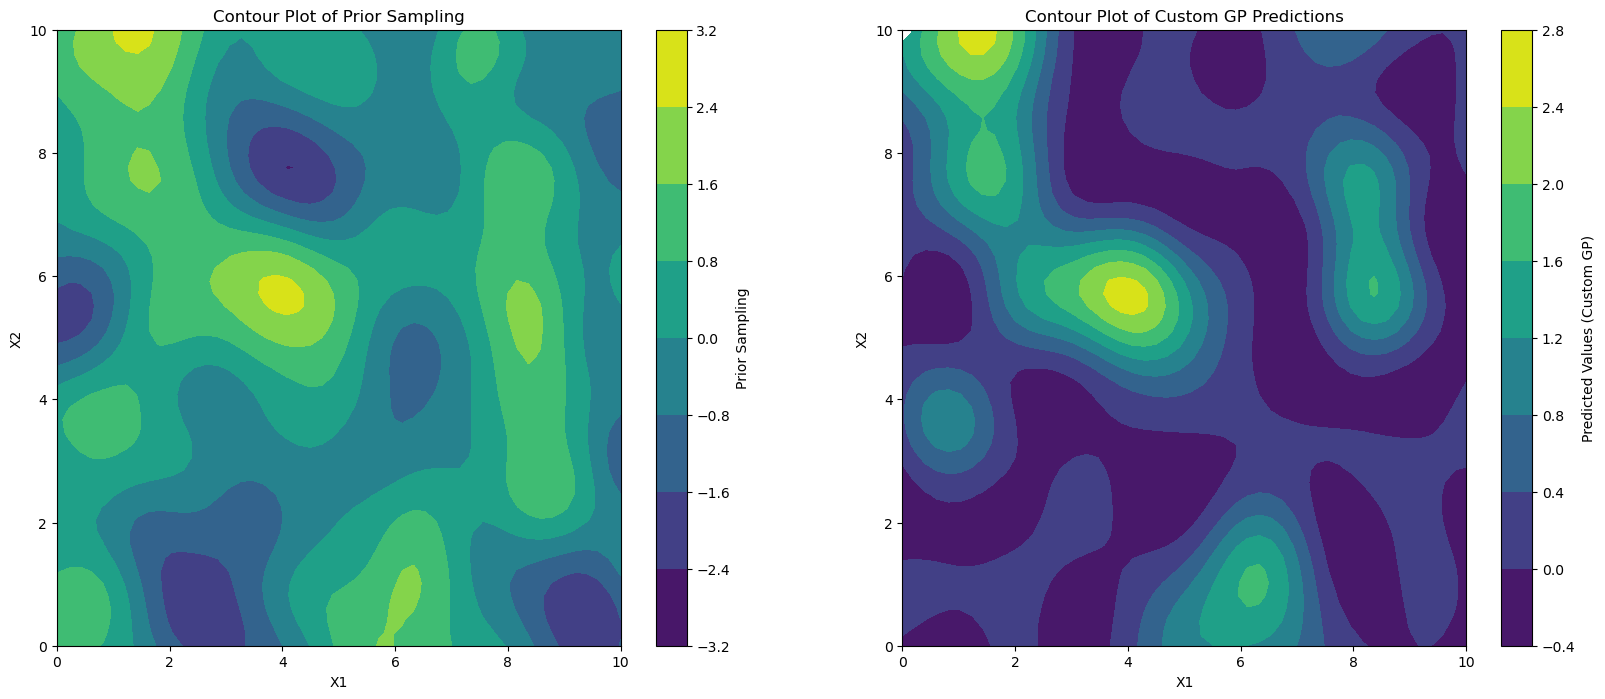

In [121]:
# Visualize custom gp results as contour plot
# Assuming X_test is 2D with shape (n_samples=, 2)
x1 = X_test[:, 0]
x2 = X_test[:, 1]
print("X_test shape: ", X_test.shape)

# Create a meshgrid for the contour plot
x1_grid, x2_grid = np.meshgrid(np.linspace(x1.min(), x1.max(), 50), np.linspace(x2.min(), x2.max(), 50))
print("x1_grid shape: ", x1_grid.shape)
print("x2_grid shape: ", x2_grid.shape)
print("process_values shape: ", process_values.shape)

# Interpolate y_pred_custom to match the grid shape
from scipy.interpolate import griddata
y_pred_custom_grid = griddata(X_test, y_pred_custom, (x1_grid, x2_grid), method='cubic')

# Reshape process_values to match the grid shape
process_values_grid = process_values.reshape(x1_grid.shape)

# Plot the contour plots side-by-side
fig, ax = plt.subplots(1, 2, figsize=(20, 8))

# Plot prior sampling
contour1 = ax[0].contourf(x1_grid, x2_grid, process_values_grid, cmap='viridis')
fig.colorbar(contour1, ax=ax[0], label='Prior Sampling')
ax[0].set_title("Contour Plot of Prior Sampling")
ax[0].set_xlabel("X1")
ax[0].set_ylabel("X2")

# Plot y_pred_custom
contour2 = ax[1].contourf(x1_grid, x2_grid, y_pred_custom_grid, cmap='viridis')
fig.colorbar(contour2, ax=ax[1], label='Predicted Values (Custom GP)')
ax[1].set_title("Contour Plot of Custom GP Predictions")
ax[1].set_xlabel("X1")
ax[1].set_ylabel("X2")

plt.show()


/var/folders/nd/v9lp325j6vx2vr517r25j0q00000gn/T/ipykernel_65981/2920487378.py:5: UserWarning: Adding colorbar to a different Figure <Figure size 1000x800 with 5 Axes> than <Figure size 640x480 with 1 Axes> which fig.colorbar is called on.
  plt.colorbar(scatter, label='Process Value')


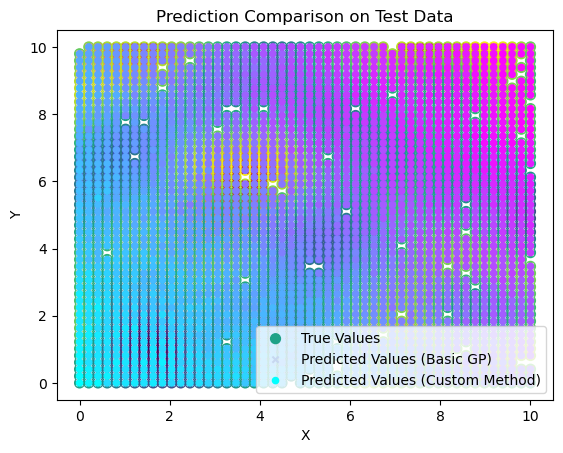

In [ ]:
# Visualize the difference in results
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap='viridis', s=50, label='True Values')
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_pred_basic, cmap='coolwarm', s=20, marker='x', label='Predicted Values (Basic GP)')
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_pred_custom, cmap='cool', s=20, marker='o', label='Predicted Values (Custom Method)')
plt.colorbar(scatter, label='Process Value')
plt.title("Prediction Comparison on Test Data")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.show()